### VAE 모형

In [ ]:
# VAE(Variational AutoEncoder) 모델

# Auto Encoder 개념을 활용한 생성 모델
# 잠재 공간(z)에 확률 분포를 저장하여 평균과 분산 파라미터 생성
# input image X를 잘 설명하는 feature를 추출하여 latent vector z에 담고 이 z를 통해 X와 유사하지만 완전히 새로운 데이터를 생성해 내는 것

# 예를 들어 한국인의 얼굴을 그리기 위해 눈, 코, 입 등의 feature를 Latent vector z에 담고, 그 z를 이용해 그럴듯한 한국인의 얼굴을 그려내는 것

In [ ]:
#   auto encoder
#   input   encoder     decoder     output
#           압축        복원
#           확률분포    

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import backend as K

(x_train,y_train),(x_test,y_test)=mnist.load_data()

x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.

x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))

In [2]:
# K.shape 설명

a=[10,20,30]
print(K.shape(a)) # 1차원

b=[[10,20,30]]
print(K.shape(b)) # [1 3], shape=(2,), 1행 3열, 2차원

tf.Tensor([3], shape=(1,), dtype=int32)
tf.Tensor([1 3], shape=(2,), dtype=int32)


In [3]:
# K.exp 설명

# 밑이 자연상수 e인 지수함수(e^x)로 변환
K.exp(1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=2.7182817>

In [4]:
zdim=32                           

def sampling(args):
    #평균, 로그분산
    z_mean,z_log_var=args

    # epsilon : 임의의 실수값
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0],zdim),mean=0.0,stddev=0.1)

    return z_mean+K.exp(0.5*z_log_var)*epsilon

In [5]:
encoder_input=Input(shape=(28,28,1))        
#                           압축

x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)

x=Flatten()(x)

z_mean=Dense(zdim)(x)
z_log_var=Dense(zdim)(x)

encoder_output=Lambda(sampling)([z_mean,z_log_var])
#                       입력          출럭
model_encoder=Model(encoder_input,[z_mean,z_log_var,encoder_output])

model_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     36928       ['conv2d_1[0][0]']               
                                                                                              

In [6]:
decoder_input=Input(shape=(zdim,))        
#                       32 확률분포값

x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)

x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same',strides=(1,1))(x)

decoder_output=x

model_decoder=Model(decoder_input,decoder_output)
#                                   28x28 이미지

model_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       1846

In [7]:
model_input=encoder_input
model_output=model_decoder(encoder_output)

model=Model(model_input,model_output)

reconstruction_loss=tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(model_input,model_output),axis=(1,2)))

kl_loss=-0.5*(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var))
kl_loss=tf.reduce_mean(tf.reduce_sum(kl_loss,axis=1))

total_loss=reconstruction_loss+kl_loss

model.add_loss(total_loss)
model.compile(optimizer='adam')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     36928       ['conv2d_1[0][0]']               
                                                                                            

In [8]:
model.fit(x_train,x_train,epochs=5,batch_size=128,validation_data=(x_test,x_test))

Epoch 1/5
469/469 [==============================] - 44s 79ms/step - loss: 128.6266 - val_loss: 75.7920
Epoch 2/5
469/469 [==============================] - 36s 78ms/step - loss: 72.6773 - val_loss: 69.7116
Epoch 3/5
469/469 [==============================] - 36s 77ms/step - loss: 69.2294 - val_loss: 68.1731
Epoch 4/5
469/469 [==============================] - 38s 81ms/step - loss: 67.8247 - val_loss: 67.0828
Epoch 5/5
469/469 [==============================] - 35s 74ms/step - loss: 67.0438 - val_loss: 66.1502


1/1 [==============================] - 0s 191ms/step
9 4
1/1 [==============================] - 0s 168ms/step


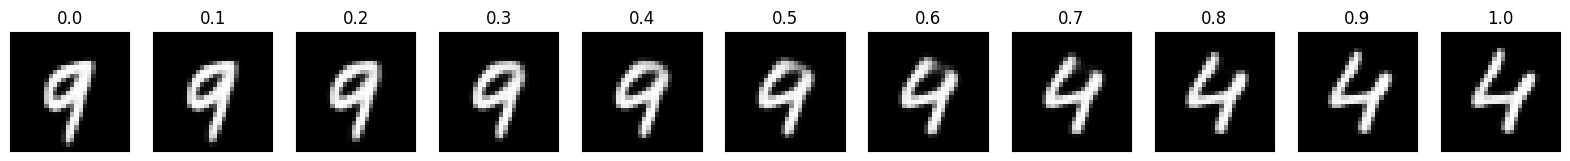

In [9]:
# 랜덤으로 2개 샘플 선택

i=np.random.randint(x_test.shape[0])
j=np.random.randint(x_test.shape[0])

x=np.array((x_test[i],x_test[j]))
z=model_encoder.predict(x)[2] # encoder_output
print(y_test[i],y_test[j])

# 영배열
zz=np.zeros((11,zdim))         # 11 x 32
#                                11개 32개 벡터

alpha=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for i in range(11):
    zz[i]=(1.0-alpha[i])*z[0]+alpha[i]*z[1] # z[0] z_mean , z[1] z_log_var

gen=model_decoder.predict(zz)

plt.figure(figsize=(20,4))

for i in range(11):
    plt.subplot(1,11,i+1)

    plt.imshow(gen[i].reshape(28,28),cmap='gray')

    plt.xticks([])
    plt.yticks([])

    plt.title(str(alpha[i]))